In [1]:
import h5py
import numpy as np
from PIL import Image
import PIL
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import Sampler
from torch.utils.data.sampler import WeightedRandomSampler
import torchvision.datasets as datasetsgh
import torchvision.transforms as transforms
from torchsummary import summary

import time
import copy
import sys
import random
import gc

In [2]:
### CNN ARCHITECTURE ###
class UNet(nn.Module):
    def conv_block(self, in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )
        
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder1 = self.conv_block(in_channels, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.encoder4 = self.conv_block(256, 512)
        self.encoder5 = self.conv_block(512, 1024)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block(1024, 512)
        
        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block(512, 256)
        
        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block(256, 128)
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(128, 64)
        
        self.output_conv = nn.Conv2d(64, out_channels, kernel_size=1)

        
    def forward(self,x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool(enc1))
        enc3 = self.encoder3(self.pool(enc2))
        enc4 = self.encoder4(self.pool(enc3))
        enc5 = self.encoder5(self.pool(enc4))
        
        dec4 = self.upconv4(enc5)
        dec4 = torch.cat((F.interpolate(dec4, size=enc4.size()[2:]), enc4), dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((F.interpolate(dec3, size=enc3.size()[2:]), enc3), dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((F.interpolate(dec2, size=enc2.size()[2:]), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((F.interpolate(dec1, size=enc1.size()[2:]), enc1), dim=1)
        dec1 = self.decoder1(dec1)
        
        output = self.output_conv(dec1)
        
        return output

In [3]:
### CUSTOM DATASET FOR HDF5 FILE ###
class HDF5Dataset:
    def __init__(self, file_path):
        self.file_path = file_path
        self.file = h5py.File(self.file_path, 'r')
        self.images = self.file['images'][:]
        #self.fractures = self.file['fractures'][:]
        #self.streams = self.file['streams'][:]
        self.ids = self.file['ids'][:]
    
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        images = self.images[idx]
        #fractures = self.fractures[idx]
        #streams = self.streams[idx]
        ids = self.ids[idx]
        
        image_tensor = torch.from_numpy(images).unsqueeze(0).float()
        #fracture_tensor = torch.from_numpy(fractures).unsqueeze(0).float()
        #stream_tensor = torch.from_numpy(streams).unsqueeze(0).float()
        ids_tensor = torch.tensor(ids, dtype=torch.int64)
        
        return {
            'images': image_tensor,
            #'fractures': fracture_tensor,
            #'streams': stream_tensor,
            'ids': ids_tensor
        }
    
    def __del__(self):
        self.file.close()

In [4]:

batch_size = 64
corner_file = 'data/data/datasets/entire_WV01_20120803164853_dataset.h5'
ds_corner = HDF5Dataset(corner_file)
dataloader_corner = DataLoader(ds_corner, batch_size=batch_size, shuffle=True, num_workers=4)


In [5]:
### SETTING DATALOADERS ###
batch_size = 32

train_file = "/data/data/datasets/train_dataset.h5"
test_file = "/data/data/datasets/test_dataset.h5"
val_file = "/data/data/datasets/val_dataset.h5"

ds_train = HDF5Dataset(train_file)
ds_test = HDF5Dataset(test_file)
ds_val = HDF5Dataset(val_file)

dataloader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=4)
dataloader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=4)

In [6]:
### LOADING MODEL ###
in_channels = 1
out_channels = 2
model = UNet(in_channels, out_channels)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Load the weights
weights_path = '/data/data/model_weights/train_dataset_batch_64_100.pth'
model.load_state_dict(torch.load(weights_path, map_location=device))

# Set to evaluation mode
model.eval()

DataParallel(
  (module): UNet(
    (encoder1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (encoder4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [7]:
images_train = []
fractures_pred_train = []
streams_pred_train = []
ids_train = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_test:
        images = batches["images"]
        #fractures = batches["fractures"]
        #streams = batches["streams"]
        #images_train.append(images.numpy()) # store images
        ids = batches["ids"]
        #ids_train.append(ids)
        
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        pred_fractures = (pred_fractures > 0.1).float()  # Threshold probabilities to get binary mask
        pred_streams = (pred_streams > 0.25).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        ids_train.append(ids)
        
        del images, ids
        
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
streams_pred_train = np.vstack(streams_pred_train)
ids_train = np.vstack(ids_train)

In [8]:
PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import Image

#img = Image.new('L', (39936, 34040))
fracture_img = Image.new('L', (39936, 34040))
stream_img = Image.new('L', (39936, 34040))

print(len(fractures_pred_train))
for i in range(len(fractures_pred_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    #image = Image.fromarray(255*images_train[i,0,:,:])
    fracture_image = Image.fromarray(255*fractures_pred_train[i,0,:,:])
    stream_image = Image.fromarray(255*streams_pred_train[i,0,:,:])
    x = int(c * 256)
    y = int(r * 256)
    #img.paste(image, (x, y))
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))
print("hi")

#img.save("data/data/different_threshold_images/original.png")
print("hi")
fracture_img.save("data/data/maps_from_models/fracture_image_test.png")
stream_img.save("data/data/maps_from_models/stream_image_test.png")

3299
hi
hi


In [22]:
images_train = []
fractures_pred_train = []
fractures_labels_train = []
streams_pred_train = []
streams_labels_train = []
ids_train = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_train:
        images = batches["images"].to(device)
        fractures = batches["fractures"].to(device)
        streams = batches["streams"].to(device)
        ids = batches["ids"]
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        pred_fractures = (pred_fractures > 0.25).float()  # Threshold probabilities to get binary mask
        pred_streams = (pred_streams > 0.5).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        fractures_labels_train.append(fractures.cpu().numpy())  # Store actual labels
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        streams_labels_train.append(streams.cpu().numpy())
        ids_train.append(ids)
        
        del images, fractures, streams, preds, ids
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
fractures_labels_train = np.vstack(fractures_labels_train)
streams_pred_train = np.vstack(streams_pred_train)
streams_labels_train = np.vstack(streams_labels_train)
ids_train = np.vstack(ids_train)

In [16]:
from PIL import Image

fracture_img = Image.new('L', (39936, 7680))
stream_img = Image.new('L', (7680, 7680))

print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][0]
    r = ids_train[i][1]
    fracture_image = Image.fromarray(fractures_pred_train[i,0,:,:])
    stream_image = Image.fromarray(streams_pred_train[i,0,:,:])
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))
    
fracture_img.save("data/data/maps_from_models/fracture_image_model_corner.png")
stream_img.save("data/data/maps_from_models/stream_image_model_corner.png")

478


In [19]:
print(ids_train[0])

[ 74 135]


In [6]:
print(fractures_pred_train[0][0].shape)

NameError: name 'fractures_pred_train' is not defined

In [23]:
from PIL import Image

fracture_img = Image.new('L', (39936, 34048))
stream_img = Image.new('L', (39936, 34048))

print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    fracture_image = Image.fromarray(255*fractures_pred_train[i,0,:,:])
    stream_image = Image.fromarray(255*streams_pred_train[i,0,:,:])
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))

11543


In [24]:
images_train = []
fractures_pred_train = []
fractures_labels_train = []
streams_pred_train = []
streams_labels_train = []
ids_train = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_test:
        images = batches["images"].to(device)
        fractures = batches["fractures"].to(device)
        streams = batches["streams"].to(device)
        ids = batches["ids"]
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        pred_fractures = (pred_fractures > 0.25).float()  # Threshold probabilities to get binary mask
        pred_streams = (pred_streams > 0.5).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        fractures_labels_train.append(fractures.cpu().numpy())  # Store actual labels
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        streams_labels_train.append(streams.cpu().numpy())
        ids_train.append(ids)
        
        del images, fractures, streams, preds, ids
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
fractures_labels_train = np.vstack(fractures_labels_train)
streams_pred_train = np.vstack(streams_pred_train)
streams_labels_train = np.vstack(streams_labels_train)
ids_train = np.vstack(ids_train)

In [25]:
print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    fracture_image = Image.fromarray(255*fractures_pred_train[i,0,:,:])
    stream_image = Image.fromarray(255*streams_pred_train[i,0,:,:])
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))

3299


In [27]:
images_train = []
fractures_pred_train = []
fractures_labels_train = []
streams_pred_train = []
streams_labels_train = []
ids_train = []
# Collect predictions and actual labels for the training set
with torch.no_grad():
    for batches in dataloader_val:
        images = batches["images"].to(device)
        fractures = batches["fractures"].to(device)
        streams = batches["streams"].to(device)
        ids = batches["ids"]
        preds = model(images)  # This will output the probability maps or segmentation maps
        pred_fractures, pred_streams = torch.chunk(preds, 2, dim=1)
        #print(pred_fractures.shape, pred_streams.shape)
        # Since UNet outputs a channel for each class per pixel, you might need to convert this to a single label per pixel
        pred_fractures = torch.sigmoid(pred_fractures)  # Apply sigmoid or softmax depending on your case
        pred_streams = torch.sigmoid(pred_streams)
        pred_fractures = (pred_fractures > 0.25).float()  # Threshold probabilities to get binary mask
        pred_streams = (pred_streams > 0.5).float()
        images_train.append(images.cpu().numpy()) # store images
        fractures_pred_train.append(pred_fractures.cpu().numpy())  # Store predictions
        fractures_labels_train.append(fractures.cpu().numpy())  # Store actual labels
        streams_pred_train.append(pred_streams.cpu().numpy())  # Store predictions
        streams_labels_train.append(streams.cpu().numpy())
        ids_train.append(ids)
        
        del images, fractures, streams, preds, ids
        
images_train = np.vstack(images_train)
fractures_pred_train = np.vstack(fractures_pred_train)
fractures_labels_train = np.vstack(fractures_labels_train)
streams_pred_train = np.vstack(streams_pred_train)
streams_labels_train = np.vstack(streams_labels_train)
ids_train = np.vstack(ids_train)

In [28]:
print(len(images_train))
for i in range(len(images_train)):
    c = ids_train[i][1]
    r = ids_train[i][0]
    fracture_image = Image.fromarray(255*fractures_pred_train[i,0,:,:])
    stream_image = Image.fromarray(255*streams_pred_train[i,0,:,:])
    x = c * 256
    y = r * 256
    fracture_img.paste(fracture_image, (x, y))
    stream_img.paste(stream_image, (x, y))

fracture_img.save("data/data/maps_from_models/fracture_image_model_3.png")
stream_img.save("data/data/maps_from_models/stream_image_model_3.png")

1650


(1650, 1, 256, 256)
(1650, 1, 256, 256)
(1650, 1, 256, 256)


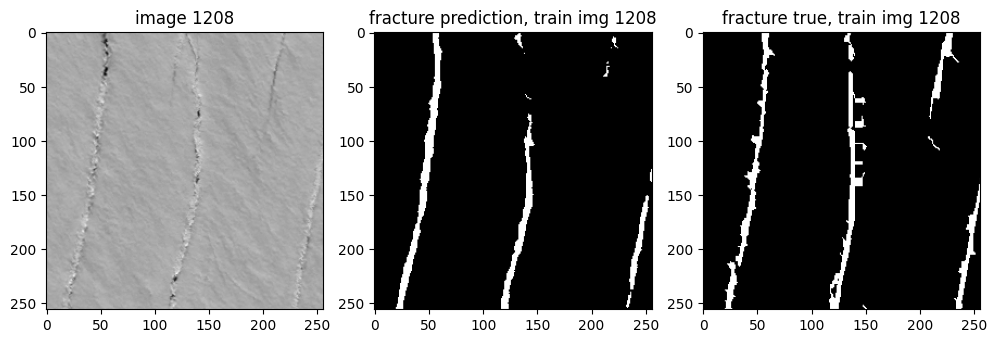

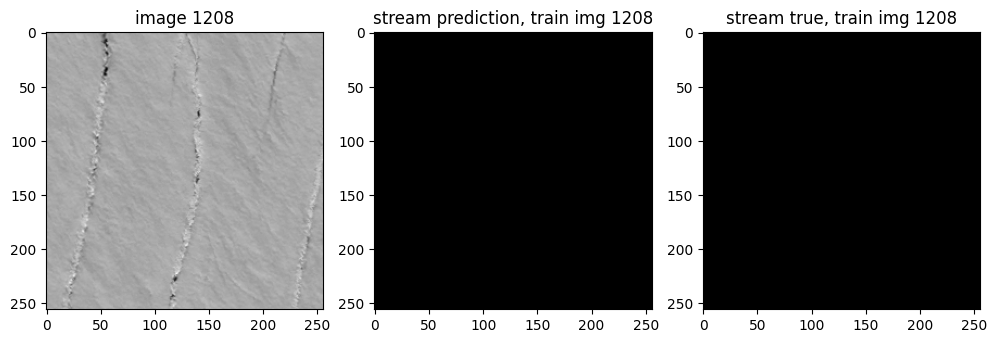

In [16]:
### PLOTTING IMAGES ###

idx_train = random.randint(0,len(fractures_labels_train))
#idx_train = 627

print(fractures_labels_train.shape)
print(fractures_pred_train.shape)
print(images_train.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(fractures_pred_train[idx_train,0,:,:],cmap='gray')
plt.title(f'fracture prediction, train img {idx_train}')
plt.subplot(1,3,3)
plt.imshow(fractures_labels_train[idx_train,0,:,:],cmap='gray')
plt.title(f'fracture true, train img {idx_train}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.subplot(1,3,1)
plt.title(f'image {idx_train}')
plt.imshow(images_train[idx_train,0,:,:], cmap='gray')
plt.subplot(1,3,2)
plt.imshow(streams_pred_train[idx_train,0,:,:],cmap='gray')
plt.title(f'stream prediction, train img {idx_train}')
plt.subplot(1,3,3)
plt.imshow(streams_labels_train[idx_train,0,:,:],cmap='gray')
plt.title(f'stream true, train img {idx_train}')
plt.tight_layout()
plt.show()